In [2]:
import numpy as np
import random as rand
from typing import List
from tqdm import tqdm
import matplotlib.pyplot as plt
import pyspiel
import itertools
from phevaluator import evaluate_cards


In [3]:
NUM_BUCKETS = 5
ALL_ACTIONS = ["f", "c", "r50", "r100", "a"]
STARTING_STACK = 100

In [23]:
class Deck:
    def __init__(self):
       self.suits = ["s", "h", "d", "c"]
       self.values = ["A", "2", "3", "4", "5", "6", "7", "8", "9", "T", "J", "Q", "K"]
       self.cards = [value + suite for suite,value in itertools.product(self.suits, self.values)]
       rand.shuffle(self.cards)
    #    self.cards = self.cards[:9]
    
    def getPlayerCards(self, player : int):
        return self.cards[2*player : 2*player+2]
    
    def getCommunityCards(self, round):
        return self.cards[4:4+round]


In [20]:
def Rank(holeCards, communityCards):
    cards = holeCards + communityCards
    return evaluate_cards(*cards)

def EHS(ourcards, boardcards, unknowncards):
    # enumerate over all turn and rivers, then define HS as the prob of winning this one outcome over unifrom opponent hand
    res = 0
    sum = 0

    print(len(unknowncards))
    possibleturnriver = [(a, b) for idx, a in enumerate(unknowncards) for b in unknowncards[idx + 1:]]
    for turn, river in possibleturnriver:
        HP = np.zeros(3)   
        board = boardcards+[turn, river]
        ourrank = Rank(ourcards, board)

        possibleoppcards = [[c,d] for (c,d) in possibleturnriver if c not in [turn, river] and d not in [turn, river]]
        for oppcards in possibleoppcards:
            opprank = Rank(oppcards, board)
            if (ourrank < opprank): HP[0] += 1
            elif (ourrank == opprank): HP[1] += 1
            else: HP[2] += 1
        
        res += (HP[0] + HP[1]/2)/(np.sum(HP))
        sum += 1

    print(res, sum)
    return res/sum

In [24]:
deck = Deck()
ourcards = deck.getPlayerCards(0)
boardcards = deck.getCommunityCards(3)
unknowncards = deck.cards[2:4] + deck.cards[7:]

print(deck.cards)
print(ourcards, boardcards, unknowncards)

['8c', '9d', '9c', 'Ad', '4s', '8d', 'Th', '9s', '7c', 'Kh', 'Ah', 'Kd', 'Ks', '7s', 'Kc', 'Jd', 'Qs', '7d', '2d', '3c', '6d', '6h', '6c', '8h', '6s', '9h', 'Ts', 'Ac', '2c', '4d', 'Qh', '3s', 'Td', '8s', '4h', '3d', '2s', 'Tc', 'Jc', '2h', '3h', '5h', '7h', 'Qd', 'Jh', '4c', 'Qc', '5s', 'As', 'Js', '5d', '5c']
['8c', '9d'] ['4s', '8d', 'Th'] ['9c', 'Ad', '9s', '7c', 'Kh', 'Ah', 'Kd', 'Ks', '7s', 'Kc', 'Jd', 'Qs', '7d', '2d', '3c', '6d', '6h', '6c', '8h', '6s', '9h', 'Ts', 'Ac', '2c', '4d', 'Qh', '3s', 'Td', '8s', '4h', '3d', '2s', 'Tc', 'Jc', '2h', '3h', '5h', '7h', 'Qd', 'Jh', '4c', 'Qc', '5s', 'As', 'Js', '5d', '5c']


In [25]:
EHS(ourcards, boardcards, unknowncards)

47
767.9924242424278 1081


0.7104462758949378

In [9]:
class InfoSetNode:
    def __init__(self):
        self.strategySum = np.zeros(NUM_BUCKETS)
        self.regretSum = np.zeros(NUM_BUCKETS)
        self.children = []


    def init_children(self):
        for _ in range(NUM_BUCKETS):
            self.children.append(InfoSetNode())
    
    def get_strat(self):
        strategy = [i if i > 0 else 0 for i in self.regretSum]

        if sum(strategy) == 0:
            strategy = np.repeat(1/NUM_BUCKETS, NUM_BUCKETS)
        else:
            strategy = strategy/sum(strategy)

        return strategy
    

    def getAverageStrategy(self):
        avgStrategy = self.strategySum

        if sum(avgStrategy) > 0:
            avgStrategy = avgStrategy/sum(avgStrategy)
        else:
            avgStrategy = np.ones(NUM_BUCKETS)/NUM_BUCKETS
        
        return avgStrategy
    
    def toString(self):
        print(self.key, self.getAverageStrategy())

In [53]:
class Game:
    def __init__(self):
        self.root0 = InfoSetNode()
        self.root1 = InfoSetNode()
        self.T = 1
        self.deck = None
    

    def cfr(self, r0: InfoSetNode, r1: InfoSetNode, history : List[str], round_num: int, p0, p1):
        """
        r0 - infoset node of player 0
        r1 - infoset node of player 1

        returns utility of current game state
        """ 
        if self.isTerminal(history, round_num):
            return self.getUtility(history)
            
        if self.isNonTerminalRoundEnd(history):
            if len(r0.children) == 0:
                r0.init_children()
                r1.init_children()
            
            next_round_num = round_num + 3 if round_num == 0 else round_num + 1
            next_hist = history[:] + [[]]
            bucket0, bucket1 = self.getBucket(next_round_num)    
            return self.cfr(r0.children[bucket0], r1.children[bucket1], next_hist, next_round_num, p0, p1)        
        
        player = self.getPlayer(history[-1])
        state_action_util_0 = np.zeros(NUM_BUCKETS)
        state_action_util_1 = np.zeros(NUM_BUCKETS)
        ACTIONS = self.getActions(history)
        
        if player == 0:
            strat = r0.get_strat()
            for i, a in enumerate(ACTIONS):
                next_hist = history[:-1] + [history[-1] + [a]]
                u0a, u1a = self.cfr(r0.children[i], r1.children[i], next_hist, round_num, strat[i]*p0, p1)
                state_action_util_0[i] = u0a
                state_action_util_1[i] = u1a

            u0 = np.dot(state_action_util_0, strat)
            u1 = np.dot(state_action_util_1, strat)
            r0.regretSum = (self.T*r0.regretSum + p1*((state_action_util_0 - u0)))/(self.T+1)
        else: 
            strat = r1.get_strat()
            for i, a in enumerate(ACTIONS):
                next_hist = history[:-1] + [history[-1] + [a]]
                u0a, u1a = self.cfr(r0.children[i], r1.children[i], next_hist, round_num, p0, strat[i]*p1)
                state_action_util_0[i] = u0a
                state_action_util_1[i] = u1a

            u0 = np.dot(state_action_util_0, strat)
            u1 = np.dot(state_action_util_1, strat)
            r1.regretSum = (self.T*r1.regretSum + p1*((state_action_util_1 - u1)))/(self.T+1)

        return u0, u1
    

    def isNonTerminalRoundEnd(self, history: List[str]) -> bool:
        assert len(history) > 0 and len(history) < 5
        lastRound = history[-1]
        is_action_closed = len(lastRound) >=2 and lastRound[-1:] == "c"
        return is_action_closed
    

    def isTerminal(self, history: List[str], round_num: int) -> bool:
        lastRound = history[-1]
        is_river_terminal = self.isNonTerminalRoundEnd(history) and round_num == 5
        is_all_in = lastRound[-2:] == "ac"
        is_fold = lastRound[-1:] == "f"
        return  is_river_terminal or is_all_in or is_fold


    def getPlayer(self, history: List[str]) -> int:
        lastRound = history[-1]
        return len(lastRound)%2


    def getPotSizeAndActions(history: List[str]):
        pot_size = 0
        remaining_stacks = np.full(2, STARTING_STACK).astype(float)
        allowed_actions = ALL_ACTIONS[:]

        for i, round in enumerate(history):
            bet_sizes = np.zeros(2)
            if i == 0:
                bet_sizes = np.ones(2)
            for j, action in enumerate(round):
                assert action in ALL_ACTIONS
                player, opp = j%2, 1-j%2
                if action == "c":
                    bet_sizes[player] = bet_sizes[opp]
                if action == "r50":
                    bet_sizes[player] = 2*bet_sizes[opp] + 0.5*pot_size
                if action == "r100":
                    bet_sizes[player] = 3*bet_sizes[opp] + pot_size
                if action == "a":
                    bet_sizes[player] = remaining_stacks[player]

            # get allowed actions for opponent
            if i == len(history) - 1:
                if 3*bet_sizes[player] + pot_size > remaining_stacks[opp]:
                    allowed_actions.remove("r100")
                if 2*bet_sizes[player] + 0.5*pot_size > remaining_stacks[opp]:
                    allowed_actions.remove("r50")
                if len(round) > 0 and round[-1] == "a":
                    allowed_actions.remove("a")

            remaining_stacks -= bet_sizes
            pot_size += np.sum(bet_sizes)
            assert np.all(remaining_stacks >= 0)
        
        return pot_size, allowed_actions


    def getActions(self, history: List[str]):
        _, allowed_actions = self.getPotSizeAndActions(history)
        return allowed_actions


    def getPlayer(self, h : str)->int:
        raise NotImplementedError
    

    def getHandRank(*args):
        raise NotImplementedError
    
    
    def getUtility(self, history: List[str]):
        p0_hand_rank = self.getBestHandRank(self, selfdeck.getPlayerCards(player) + deck.getCommunityCards())
        p1_hand_rank = self.getBestHandRank(self,  deck.getPlayerCards(opp) + deck.getCommunityCards())

        is_fold = h[-1:] == "f"
        is_river_showdown = h.count("|") == 3 and (h[-2:] == "cc" or h[-2:]=="rc")
        is_all_in_call = h[-2:]=="ac"

        if is_fold:
            return u
        if is_river_showdown or is_all_in_call:
            if playerHandRank > oppHandRank:
                return u
            if playerHandRank < oppHandRank:
                return -u
            return 0



    def getBucket(self, round_num: int) -> int:
        raise NotImplementedError
    

    def train(self, epochs):
        util = 0
        for _ in tqdm(range(epochs)):
            self.deck = Deck()
            self.T += 1
            util += self.cfr(self.root0, self.root1, [[]], 1, 1)

        print("Average game value: " + str(util / epochs))
        keys = list(self.infoSets.keys())
        keys.sort()
        for k in keys:
            self.infoSets[k].toString()

NameError: name 'InfoSetNode' is not defined

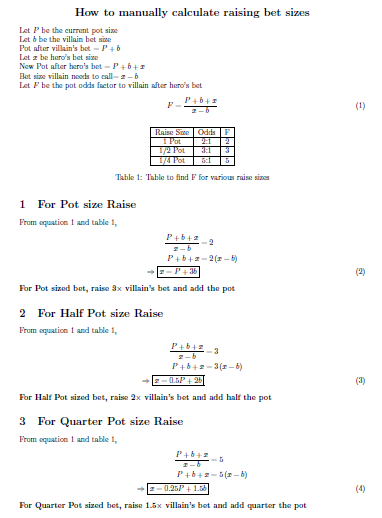

In [ ]:
def handStrength(self, ourcards, boardcards):
    ahead = tied = behind = 0
    ourrank = self.getHandRank(ourcards, boardcards)

    for oppcards in 
        opprank = Rank(oppcards, boardcards)
        if ourrank > opprank: ahead += 1
        elif ourrank == opprank: tied += 1
        else: behind += 1

    handstrength = (ahead + tied / 2) / (ahead + tied + behind)
    return handstrength

def HandPotential(ourcards, boardcards):
    // Hand potential array, each index represents ahead, tied, and behind
    integer array HP[3][3] // initialize to 0
    integer array HPTotal[3] // initialize to 0
    ourrank = Rank(ourcards, boardcards)

    // Consider all two card combinations of the remaining cards for the opponent
    for each case(oppcards) {
        opprank = Rank(oppcards, boardcards)
        if (ourrank > opprank) index = ahead
        else if (ourrank == opprank) index = tied
        else index = behind
        HPTotal[index] += 1

        // All possible board cards to come
        for each case(turn, river) {
            // Final 5-card board
            board = [boardcards, turn, river]
            ourbest = Rank(ourcards, board)
            oppbest = Rank(oppcards, board)
            if (ourbest > oppbest) HP[index][ahead] += 1
            else if (ourbest == oppbest) HP[index][tied] += 1
            else HP[index][behind] += 1
        }
    }

    Ppot = (HP[behind][ahead] + HP[behind][tied] / 2 + HP[tied][ahead] / 2) / (HPTotal[behind] + HPTotal[tied])
    Npot = (HP[ahead][behind] + HP[tied][behind] / 2 + HP[ahead][tied] / 2) / (HPTotal[ahead] + HPTotal[tied])

    return Ppot, Npot

    

In [ ]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.4f}".format(x)})

game = Game()

game.train(100000)

100%|██████████| 100000/100000 [00:03<00:00, 31804.85it/s]

Average game value: -0.05521727037715483
0 [0.7514 0.2486]
0b [1.0000 0.0000]
0p [0.6627 0.3373]
0pb [1.0000 0.0000]
1 [0.9999 0.0001]
1b [0.6675 0.3325]
1p [0.9998 0.0002]
1pb [0.4113 0.5887]
2 [0.2665 0.7335]
2b [0.0000 1.0000]
2p [0.0000 1.0000]
2pb [0.0000 1.0000]
